# Análisis de distribución de casos + de Madrid

## Objetivo

El procedimiento de comunicación de datos positivos de Covid de la Comunidad de Madrid se basa en comunicar un número total diarios, primera página de este pdf por ejemplo, mencionándose, a continuación, los que corresponden al día anterior. El resto se distribuyen entre días pasados. Nos preguntamos como se hace ese reparto, hasta cuando se "reparten" esos positivos, ¿cuánto hacia atrás se están llevando?, qué equivale a decir: con qué retraso se están asignando esos casos, de hoy por ejemplo, a sus fechas reales?.
En este trabajo vamos a intentar responder a esa pregunta

## Pasos a seguir

1. Descargaremos los ficheros pdf del repositorio de la Comunidad de Madrid, desde el 01 de Septiembre. Este es, como ejemplo, el [fichero](https://www.comunidad.madrid/sites/default/files/doc/sanidad/200901_cam_covid19.pdf)  del 1 de Septiembre.
2. Leeremos esos ficheros buscando las tablas de acumulado, que aparecen en la página 2 y 3 de ese documento.
3. Construiremos, con esa información, la "visión" de casos que se ha tenido en cada uno de los días desde Septiembre, guardándolas como columnas de un `pandas`
4. A continuación calcularemos los incrementales diarios de cada día, es decir los positivos comunicados en el documento de un día en concreto: a qué días se están asignando.
5. En este punto tendremos un `pandas`con los datos de cada día de publicación en columna, y cada fila representa el día al que se asocia.
6. Por último desplazaremos cada columna para que cada fila represente de manera relativa días de diferencia con el de publicación (así hablaremos de que un dato presentado en día `t` se ha asignado a un día `t-3` por ejemplo, tres días anteriores.
7. Finalmente preparemos un gráfico para visualizar este comportamiento.

Para los pasos 1 y 2 he utilizado el script escrito por [@alfonsotwr](https://twitter.com/alfonsotwr) , disponible en su [github](https://github.com/alfonsotwr/snippets/tree/master/covidia-cam). Todo el código de esos pasos es suyo. 
Manos a la obra

## Código

Tenemos un montón de librerias con las que vamos a trabajar, no he tenido ningún problema en instalar aquellas no disponibles en el entorno Anaconda con el que trabajo por medio de `pip install libreria` realizado desde un terminal abierto desde el entorno `env`.

In [1]:
import os.path as pth
import datetime as dt
import time
from glob import glob
import re
import pandas as pd
import numpy as np

import requests
from shutil import copyfile

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import cm
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.dates import (YEARLY, MONTHLY, DateFormatter, WeekdayLocator, MonthLocator,DayLocator,
                              rrulewrapper, RRuleLocator, drange)
import seaborn as sns
import matplotlib.colors as colors

import numpy as np
from datetime import datetime
import seaborn as sns
%matplotlib inline

from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.pdfpage import PDFPage
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from io import StringIO

Preparamos las expresiones regulares que nos ayudarán en la interpretación de la información que sacamos de los pdf.

In [2]:
expnumber = re.compile(r'^ *(\d+(?: ?\. ?\d+)*)(?:[^\d/]|\s|\(|$|\.[^\d/]|\.\s|\.$)', re.M)
expfecha = re.compile(r'(\d\d)/(\d\d)/(\d\d\d\d)') #fechas
expacum = re.compile(r'\n2 \n7 \n11 \n[\d \n]+') #acumulados, 2,7,11 son los primeros datos de la serie
expnumber2 = re.compile(r'\d\d\d\d\d+')

Definimos variables que nos ayuden en la gestión de los nombres de los ficheros.

In [3]:
URL_TPL = 'https://www.comunidad.madrid/sites/default/files/doc/sanidad/{:02d}{:02d}{:02d}_cam_covid19.pdf'
FN_TPL = '{:02d}{:02d}{:02d}_cam_covid19.pdf'
FN_TPL_txt = '{:02d}{:02d}{:02d}_cam_covid19.txt'
datadir='data/'

In [4]:
ALWAYS_UPDATE = True
def descarga(url, fn, isbinary=False, isascii=False, isbackup=False,
             prevpage=None):
    #función para descargar el fichero depositado en url y que guardamos con 
    #nombre fn
    
    
    today = dt.date.today()

    ret = True

    if pth.isfile(fn):
        modifiedTime = pth.getmtime(fn)
        changed = dt.datetime.fromtimestamp(modifiedTime).date()

        if isbackup:
            basename = pth.basename(fn)
            rootfn, ext = pth.splitext(basename)
            dirname = pth.dirname(fn)
            changedstr = str(changed)

            backupfn = pth.join(dirname, 'backup',
                                rootfn + '-' + changedstr + ext)
            print('Backup: {} -> {}'.format(fn, backupfn))
            copyfile(fn, backupfn)


    if not pth.isfile(fn) or changed != today or ALWAYS_UPDATE:
        print('Descargando:', url)
        headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
        with requests.Session() as s:
            if prevpage:
                s.get(prevpage, headers=headers)
            r = s.get(url, headers=headers)
        if r.status_code == requests.codes.ok:
            if isbinary:
                with open(fn, 'wb') as fp:
                    fp.write(r.content)
            elif isascii:
                content = r.content
                text = r.content.decode('ascii', 'ignore')
                with open(fn, 'w', encoding='utf-8') as fp:
                    fp.write(text)
            else:
                with open(fn, 'w', encoding='utf-8') as fp:
                    fp.write(r.text)
        else:
            print('ERROR', r.status_code, 'descargando:', fn)
            ret = False

    return ret

In [5]:
# Extract PDF text using PDFMiner. Adapted from
# http://stackoverflow.com/questions/5725278/python-help-using-pdfminer-as-a-library

def pdf_to_text(pdfname, pagenum=None):

    # PDFMiner boilerplate
    rsrcmgr = PDFResourceManager()
    sio = StringIO()
    laparams = LAParams()
    device = None
    try:
        device = TextConverter(rsrcmgr, sio, laparams=laparams)
        interpreter = PDFPageInterpreter(rsrcmgr, device)

        # Extract text
        with open(pdfname, 'rb') as fp:
            for i, page in enumerate(PDFPage.get_pages(fp)):
                if pagenum is None or pagenum == i:
                    interpreter.process_page(page)

        # Get text from StringIO
        text = sio.getvalue()
    finally:
        # Cleanup
        sio.close()
        if device is not None:
            device.close()

    return text

In [6]:
# descargamos los ficheros pdf desde 1 de Septiembre hasta hoy
# sacado del script de @alfonsotwr mencionado
today = dt.date.today()

un_dia = dt.timedelta(days=1)
tomorrow = today+un_dia
desde = dt.date(year=2020,month=9,day=1)

date_array = np.arange(today-un_dia, tomorrow,
                                    np.timedelta64(1,'D'), dtype='datetime64')
date_array_download = np.arange(today-2*un_dia, today+un_dia,
                                    np.timedelta64(1,'D'), dtype='datetime64')

for dia in date_array_download:
    pdfdir = 'data/'
    dia_dt = dia.item()
    #if dia_dt.weekday() in [5,6]:
    #    continue
    fn = pdfdir + FN_TPL.format(dia_dt.year % 100, dia_dt.month, dia_dt.day)
    url = URL_TPL.format(dia_dt.year % 100, dia_dt.month, dia_dt.day)
    ret = descarga(url, fn, isbinary=True)
    time.sleep(1)
    if not ret:
        changed = False
        if dia_dt == dt.date(2020, 9, 2):  # special cases
                url = url.replace('/doc/sanidad', '')
                changed = True
        if changed:
            descarga(url, fn, isbinary=True)
            time.sleep(1)

Descargando: https://www.comunidad.madrid/sites/default/files/doc/sanidad/201204_cam_covid19.pdf
Descargando: https://www.comunidad.madrid/sites/default/files/doc/sanidad/201205_cam_covid19.pdf
Descargando: https://www.comunidad.madrid/sites/default/files/doc/sanidad/201206_cam_covid19.pdf
ERROR 404 descargando: data/201206_cam_covid19.pdf


In [7]:
for dia in date_array:
    print (dia)

2020-12-05
2020-12-06


In [8]:
#Creamos los txt con los datos
#basado en el script de @alfonsotwr mencionado

un_dia = dt.timedelta(days=1)
tomorrow = today+un_dia
desde = dt.date(year=2020,month=9,day=1)
today = dt.date.today()
date_array = np.arange(today-un_dia, today,
                                    np.timedelta64(1,'D'), dtype='datetime64')

for dia in date_array:
    dia_dt = dia.item()
    #if (dia_dt.weekday() in [5,6]) or (dia_dt.month ==10 and dia_dt.day == 12):
    #    continue
    
    fn = pdfdir + FN_TPL.format(dia_dt.year % 100, dia_dt.month, dia_dt.day)
    #print(fn)
    fn1 = fn.replace('.pdf', '_1.txt')
    fn2 = fn.replace('.pdf', '_2.txt')
    fn3 = fn.replace('.pdf', '_3.txt')
    
    #datos de la primera página del pdf
    print('Creating:', fn1)
    page1 = pdf_to_text(fn, pagenum=0)
    #with open(fn1, 'w', encoding='utf-8') as fp:
    with open(fn1, 'w') as fp:    
        fp.write(page1)
    
    #datos de la segunda página del pdf
    print('Creating:', fn2)
    page2 = pdf_to_text(fn, pagenum=1)
    #with open(fn2, 'w', encoding='utf-8') as fp:
    with open(fn2, 'w') as fp:     
        fp.write(page2)
    
    #datos de la tercera página del pdf
    print('Creating:', fn3)
    page3 = pdf_to_text(fn, pagenum=2)
    #with open(fn3, 'w', encoding='utf-8') as fp:
    with open(fn3, 'w') as fp:
        fp.write(page3)

Creating: data/201205_cam_covid19_1.txt
Creating: data/201205_cam_covid19_2.txt
Creating: data/201205_cam_covid19_3.txt


In [10]:
#creamos los ficheros csv a partir de los ficheros txt creados antes.
#basado en el script de @alfonsotwr mencionado

csvfn = datadir + 'madrid-series.csv'
un_dia = dt.timedelta(days=1)

desde = dt.date(year=2020,month=9,day=1)
today = dt.date.today()
tomorrow = today+un_dia
date_array = np.arange(today-un_dia*4,today,
                                    np.timedelta64(1,'D'), dtype='datetime64')


for dia in date_array:
    df = pd.DataFrame()
    pdfdir = 'data/'
    dia_dt = dia.item()
    if dia_dt.weekday() in [5,6]  or (dia_dt.month ==10 and dia_dt.day == 12):
        continue
    fn = pdfdir + FN_TPL.format(dia_dt.year % 100, dia_dt.month, dia_dt.day)
    #print(fn)
    fn2 = fn.replace('.pdf', '_2.txt')
    fn3 = fn2.replace('_2.txt', '_3.txt')
    print(fn2)
    #with open(fn2, encoding='utf-8') as fp:
    with open(fn2) as fp:
        text = fp.read()

    m = expacum.search(text)

    assert m, 'Debe ajustarse expacum con los primeros valores'

    accum = [int(x) for x in m.group().split()]

    dates = []
    for m in expfecha.finditer(text):
        dates.append(dt.datetime(int(m.group(3)), int(m.group(2)),
                                    int(m.group(1))))

    #accum2 = [int(x.group()) for x in expnumber2.finditer(text)
    #        if int(x.group()) > accum[-1]]
    #añadido para 2 noviembre
    dates = sorted(dates)
    
    accum2 = sorted(int(x.group()) for x in expnumber2.finditer(text)
                     if int(x.group()) > accum[-1])
    accum += accum2

    assert len(accum) == len(dates), 'La serie acumulada no concuerda para _2'

    print(fn3)
    #with open(fn3, encoding='utf-8') as fp:
    with open(fn3) as fp:   
        text = fp.read()

    dates2 = []
    for m in expfecha.finditer(text):
        dates2.append(dt.datetime(int(m.group(3)), int(m.group(2)),
                                      int(m.group(1))))
    dates += sorted(dates2)

    accum2 = [int(x.group()) for x in expnumber2.finditer(text)]
    
    
    
    accum += sorted(accum2)

    # assert len(accum) == len(dates), 'La serie acumulada no concuerda para _3'

    sr = pd.Series(accum, index=dates).sort_index()
    sr.name = 'PCR+'
    sr.index.name = 'Fecha'
    df2 = sr.to_frame()

    #if df.index[-1] != df2.index[-1] + dt.timedelta(1):
    #    raise RuntimeError('Última fecha de las tablas no coincide')

    # pd.set_option('display.max_rows', None)
    # print(sr)
    # print(sr.diff())
    assert all(sr.diff().dropna() >= 0), 'La serie acumulada no es creciente'
    assert all((sr.index[1:] - sr.index[:-1]).days > 0), 'Fechas no suben'

    csvfn = datadir + 'madrid_pcr_' + dia.item().strftime('_%d_%m')+'.csv'
    print('Escribiendo', csvfn)
    df2.to_csv(csvfn, line_terminator='\r\n')

data/201202_cam_covid19_2.txt


AssertionError: Debe ajustarse expacum con los primeros valores

A continuación vamos a generar el pandas con todas la información que hemos conseguido de los ficheros pdf

In [10]:

df=pd.DataFrame() #creamos un pandas vacío para trabajar

for dia in date_array[::-1]: #iteramos sobre todo el tiempo de análisis, desde 1 Sept
    dia_dt = dia.item() # date_array es un array de tiempo de numpy, con item() pasamos a datetime
    if dia_dt.weekday() in [5,6] or (dia_dt.month ==10 and dia_dt.day == 12): # en los fines de semana no se publican datos
        continue
    #construimos el nombre del ficher csv en el que hemos guardado la info.
    nombre_csv=datadir+'madrid_pcr__{:02d}_{:02d}.csv'.format(dia_dt.day,dia_dt.month)
    
    #leemos el csv en un pandas df1
    df1=pd.read_csv(nombre_csv).set_index('Fecha')
    #asigbamos como nombre de columna el día en el que se publica (dia)
    nombre_columna='{:02d}-{:02d}-{:02d}'.format(dia_dt.year,dia_dt.month,dia_dt.day)
    df1.columns=[nombre_columna]
    
    #concatenamos es pandas recién leído con el principal
    df = pd.concat([df,df1], axis=1)
#invertimos el orden de las columnas para tener a la izquierda la fecha más antigua
df = df[df.columns[::-1]]
df.to_csv('madrid_25_11_20_.csv')
#calculamos las diferencias de cada fila respecto a la anterior en tiempo, ya que hemos leído
#datos acumulados
#df.fillna(0,inplace=True)
df = df.diff()
df.fillna(0,inplace=True)
df = df.diff(axis=1)
#df3=df3[df3.columns[::-1]]
#df3 = df.diff(axis=1)
#calculamos las diferencias de cada columna con la anterior y vemos los datos
#que se van acumulando cada día
#df3.fillna(0,inplace=True)
#df3 = df.diff(axis=1)
#convertimos los NaN a cero


In [11]:
date_array

array(['2020-09-01', '2020-09-02', '2020-09-03', '2020-09-04',
       '2020-09-05', '2020-09-06', '2020-09-07', '2020-09-08',
       '2020-09-09', '2020-09-10', '2020-09-11', '2020-09-12',
       '2020-09-13', '2020-09-14', '2020-09-15', '2020-09-16',
       '2020-09-17', '2020-09-18', '2020-09-19', '2020-09-20',
       '2020-09-21', '2020-09-22', '2020-09-23', '2020-09-24',
       '2020-09-25', '2020-09-26', '2020-09-27', '2020-09-28',
       '2020-09-29', '2020-09-30', '2020-10-01', '2020-10-02',
       '2020-10-03', '2020-10-04', '2020-10-05', '2020-10-06',
       '2020-10-07', '2020-10-08', '2020-10-09', '2020-10-10',
       '2020-10-11', '2020-10-12', '2020-10-13', '2020-10-14',
       '2020-10-15', '2020-10-16', '2020-10-17', '2020-10-18',
       '2020-10-19', '2020-10-20', '2020-10-21', '2020-10-22',
       '2020-10-23', '2020-10-24', '2020-10-25', '2020-10-26',
       '2020-10-27', '2020-10-28', '2020-10-29', '2020-10-30',
       '2020-10-31', '2020-11-01', '2020-11-02', '2020-

In [12]:
df.tail(35)

,2020-09-01,2020-09-02,2020-09-03,2020-09-04,2020-09-07,2020-09-08,2020-09-09,2020-09-10,2020-09-11,2020-09-14,...,2020-11-16,2020-11-17,2020-11-18,2020-11-19,2020-11-20,2020-11-23,2020-11-24,2020-11-25,2020-11-26,2020-11-27
2020-10-23,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,8.0,8.0,3.0,4.0,11.0,1.0,7.0,1.0,3.0
2020-10-24,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.0,4.0,0.0,3.0,1.0,2.0,1.0,2.0,1.0,0.0
2020-10-25,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,9.0,4.0,2.0,4.0,4.0,10.0,3.0,1.0,4.0,4.0
2020-10-26,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11.0,5.0,7.0,7.0,11.0,7.0,5.0,5.0,8.0,3.0
2020-10-27,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,15.0,5.0,11.0,10.0,6.0,10.0,3.0,8.0,20.0,4.0
2020-10-28,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,20.0,7.0,3.0,8.0,5.0,7.0,6.0,9.0,6.0,1.0
2020-10-29,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11.0,8.0,14.0,12.0,7.0,12.0,5.0,4.0,5.0,8.0
2020-10-30,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,17.0,7.0,7.0,2.0,1.0,14.0,2.0,6.0,3.0,7.0
2020-10-31,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,1.0,2.0,3.0,1.0,5.0,3.0,2.0,-1.0,4.0
2020-11-01,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,1.0,7.0,0.0,2.0,4.0,5.0,2.0,3.0,2.0


Hagamos comprobaciones para asegurar que los datos son correctos: 

La suma de la columna del `2020-10-01`nos ha de dar el total de casos reportados ese día. Y efectivamente podemos chequear ese resultados [aquí](https://www.comunidad.madrid/sites/default/files/doc/sanidad/201002_cam_covid19.pdf)

In [14]:
df['2020-10-01'].sum()

4342.0

In [16]:
df.to_csv('madrid_25_11_20')

Lo mismo con el día [02/09](https://www.comunidad.madrid/sites/default/files/200902_cam_covid19.pdf). Resultado también correcto:

In [17]:
df['2020-09-02'].sum()

2617.0

Y de igual manera podemos ver que la suma de la fila correspondiente al día 5 de Septiembre:

In [18]:
df.loc['2020-09-05'].sum()

1630.0

coincide con el número de casos asignados a ese día en la tabla más actualizada, la del día [02/10](https://www.comunidad.madrid/sites/default/files/doc/sanidad/201002_cam_covid19.pdf)

Hagamos una parada para interpretar los datos que hemos conseguido. Esta es una imagen del `pandas`:

In [19]:
pd.set_option('display.max_columns', None) #para ver todas las columnas en pantalla
df.tail(30)

,2020-09-01,2020-09-02,2020-09-03,2020-09-04,2020-09-07,2020-09-08,2020-09-09,2020-09-10,2020-09-11,2020-09-14,2020-09-15,2020-09-16,2020-09-17,2020-09-18,2020-09-21,2020-09-22,2020-09-23,2020-09-24,2020-09-25,2020-09-28,2020-09-29,2020-09-30,2020-10-01,2020-10-02,2020-10-05,2020-10-06,2020-10-07,2020-10-08,2020-10-09,2020-10-13,2020-10-14,2020-10-15,2020-10-16,2020-10-19,2020-10-20,2020-10-21,2020-10-22,2020-10-23,2020-10-26,2020-10-27,2020-10-28,2020-10-29,2020-10-30,2020-11-02,2020-11-03,2020-11-04,2020-11-05,2020-11-06,2020-11-09,2020-11-10,2020-11-11,2020-11-12,2020-11-13,2020-11-16,2020-11-17,2020-11-18,2020-11-19,2020-11-20,2020-11-23,2020-11-24
2020-10-25,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,223.0,27.0,64.0,11.0,13.0,11.0,2.0,2.0,11.0,7.0,4.0,2.0,3.0,10.0,7.0,9.0,4.0,2.0,4.0,4.0,10.0,3.0
2020-10-26,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1254.0,134.0,199.0,67.0,72.0,3.0,47.0,34.0,27.0,31.0,6.0,12.0,18.0,1.0,11.0,5.0,7.0,7.0,11.0,7.0,5.0
2020-10-27,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1340.0,211.0,149.0,118.0,11.0,46.0,27.0,26.0,36.0,8.0,16.0,14.0,16.0,15.0,5.0,11.0,10.0,6.0,10.0,3.0
2020-10-28,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1147.0,245.0,156.0,0.0,74.0,57.0,37.0,45.0,9.0,14.0,18.0,16.0,20.0,7.0,3.0,8.0,5.0,7.0,6.0
2020-10-29,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1244.0,260.0,6.0,97.0,82.0,31.0,57.0,7.0,25.0,17.0,10.0,11.0,8.0,14.0,12.0,7.0,12.0,5.0
2020-10-30,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1479.0,20.0,168.0,125.0,54.0,88.0,13.0,20.0,23.0,13.0,17.0,7.0,7.0,2.0,1.0,14.0,2.0
2020-10-31,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,249.0,7.0,77.0,54.0,14.0,10.0,4.0,6.0,14.0,3.0,4.0,1.0,2.0,3.0,1.0,5.0,3.0
2020-11-01,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,178.0,47.0,16.0,58.0,17.0,29.0,4.0,6.0,9.0,6.0,10.0,1.0,7.0,0.0,2.0,4.0,5.0
2020-11-02,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,251.0,62.0,36.0,25.0,28.0,3.0,10.0,11.0,7.0,10.0,4.0,4.0,4.0,4.0,6.0,2.0
2020-11-03,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1206.0,152.0,213.0,168.0,27.0,37.0,54.0,35.0,33.0,9.0,5.0,5.0,4.0,10.0,10.0


**¿qué significa lo que vemos?**:
1. En el eje `x`podemos observar los días de publicación 
2. En el eje `y`podemos observar los días a los que se asigna los datos publicados el día expresado en `x`. De esa manera vemos por ejemplo que en la columna del día 22/09 (recordemos: datos publicados ese día) fila `2020-09-17`tenemos 440 casos. Es decir: del total de resultados publicados el día 22/09 440 se asignan al día 17 de Septiembre
3. Obviamente la esquina inferior izquierda está a cero corresponde a fechas posteriores a la publicación.

Nos queda el último paso: desplacemos las columnas hacía abajo para que en cada fila tengamos siempre los mismos días hacia atrás con respecto a cualquier columna. 

In [20]:
df1 = df.copy()

In [21]:
#tenemos que bajar tantos días como estemos alejados del último día
ref= dt.datetime.strptime(df.columns[0],'%Y-%m-%d')
rango = (dt.datetime.strptime(df.columns[-1],'%Y-%m-%d')-ref).days
for orden,columna in enumerate(df1.columns):
    desplazamiento = rango-(dt.datetime.strptime(columna, '%Y-%m-%d')-ref).days
    df1[columna] = df1[columna].shift(periods=desplazamiento)
    print (columna,desplazamiento)
df1.index = np.arange(-len(df1.index),0) #cambiamos el nombre al índice para que nos indique, quitado el +1
#el número de días hacia atrás. Ahora cada celda en la fila no se refiere al mismo día, sino 
#al mismo "desplazamiento de días"

2020-09-01 84
2020-09-02 83
2020-09-03 82
2020-09-04 81
2020-09-07 78
2020-09-08 77
2020-09-09 76
2020-09-10 75
2020-09-11 74
2020-09-14 71
2020-09-15 70
2020-09-16 69
2020-09-17 68
2020-09-18 67
2020-09-21 64
2020-09-22 63
2020-09-23 62
2020-09-24 61
2020-09-25 60
2020-09-28 57
2020-09-29 56
2020-09-30 55
2020-10-01 54
2020-10-02 53
2020-10-05 50
2020-10-06 49
2020-10-07 48
2020-10-08 47
2020-10-09 46
2020-10-13 42
2020-10-14 41
2020-10-15 40
2020-10-16 39
2020-10-19 36
2020-10-20 35
2020-10-21 34
2020-10-22 33
2020-10-23 32
2020-10-26 29
2020-10-27 28
2020-10-28 27
2020-10-29 26
2020-10-30 25
2020-11-02 22
2020-11-03 21
2020-11-04 20
2020-11-05 19
2020-11-06 18
2020-11-09 15
2020-11-10 14
2020-11-11 13
2020-11-12 12
2020-11-13 11
2020-11-16 8
2020-11-17 7
2020-11-18 6
2020-11-19 5
2020-11-20 4
2020-11-23 1
2020-11-24 0


Se ve mejor mostrando el `pandas`resultado por pantalla

In [22]:
df1.tail(25)

,2020-09-01,2020-09-02,2020-09-03,2020-09-04,2020-09-07,2020-09-08,2020-09-09,2020-09-10,2020-09-11,2020-09-14,2020-09-15,2020-09-16,2020-09-17,2020-09-18,2020-09-21,2020-09-22,2020-09-23,2020-09-24,2020-09-25,2020-09-28,2020-09-29,2020-09-30,2020-10-01,2020-10-02,2020-10-05,2020-10-06,2020-10-07,2020-10-08,2020-10-09,2020-10-13,2020-10-14,2020-10-15,2020-10-16,2020-10-19,2020-10-20,2020-10-21,2020-10-22,2020-10-23,2020-10-26,2020-10-27,2020-10-28,2020-10-29,2020-10-30,2020-11-02,2020-11-03,2020-11-04,2020-11-05,2020-11-06,2020-11-09,2020-11-10,2020-11-11,2020-11-12,2020-11-13,2020-11-16,2020-11-17,2020-11-18,2020-11-19,2020-11-20,2020-11-23,2020-11-24
-25,NaN,2.0,0.0,0.0,16.0,1.0,5.0,2.0,4.0,33.0,4.0,1.0,8.0,9.0,23.0,13.0,7.0,7.0,7.0,29.0,6.0,5.0,2.0,4.0,15.0,12.0,2.0,4.0,6.0,23.0,2.0,4.0,9.0,14.0,6.0,1.0,1.0,3.0,12.0,10.0,3.0,0.0,9.0,12.0,1.0,1.0,1.0,1.0,11.0,2.0,1.0,5.0,7.0,13.0,8.0,0.0,4.0,11.0,12.0,2.0
-24,NaN,1.0,3.0,0.0,32.0,1.0,1.0,4.0,11.0,31.0,7.0,2.0,16.0,16.0,31.0,3.0,3.0,11.0,5.0,30.0,5.0,1.0,16.0,8.0,17.0,1.0,3.0,0.0,5.0,8.0,1.0,3.0,11.0,11.0,1.0,1.0,3.0,8.0,11.0,0.0,1.0,2.0,8.0,9.0,0.0,1.0,3.0,9.0,18.0,1.0,5.0,4.0,7.0,9.0,4.0,2.0,7.0,6.0,14.0,3.0
-23,NaN,2.0,3.0,0.0,16.0,1.0,20.0,9.0,9.0,27.0,0.0,1.0,14.0,7.0,10.0,3.0,2.0,9.0,4.0,10.0,3.0,6.0,93.0,10.0,6.0,3.0,12.0,5.0,5.0,5.0,10.0,8.0,13.0,10.0,0.0,6.0,83.0,3.0,1.0,2.0,2.0,9.0,4.0,3.0,0.0,1.0,16.0,6.0,6.0,2.0,7.0,16.0,3.0,6.0,4.0,7.0,10.0,5.0,5.0,5.0
-22,NaN,4.0,9.0,0.0,11.0,1.0,10.0,9.0,10.0,5.0,6.0,9.0,16.0,15.0,9.0,4.0,10.0,11.0,9.0,6.0,1.0,94.0,73.0,12.0,4.0,5.0,6.0,4.0,11.0,9.0,2.0,6.0,18.0,6.0,3.0,14.0,74.0,7.0,0.0,1.0,14.0,7.0,5.0,4.0,3.0,7.0,10.0,8.0,7.0,3.0,10.0,12.0,8.0,9.0,5.0,11.0,8.0,7.0,4.0,2.0
-21,NaN,2.0,7.0,0.0,20.0,7.0,2.0,6.0,6.0,16.0,7.0,12.0,10.0,18.0,13.0,13.0,8.0,8.0,10.0,19.0,6.0,63.0,113.0,12.0,8.0,11.0,6.0,7.0,12.0,25.0,7.0,11.0,10.0,7.0,10.0,14.0,116.0,27.0,14.0,8.0,3.0,5.0,16.0,1.0,3.0,4.0,11.0,7.0,8.0,10.0,10.0,16.0,18.0,11.0,5.0,3.0,12.0,1.0,6.0,10.0
-20,NaN,22.0,10.0,0.0,41.0,8.0,7.0,10.0,7.0,29.0,11.0,8.0,14.0,5.0,38.0,5.0,8.0,13.0,3.0,35.0,16.0,98.0,117.0,2.0,18.0,2.0,10.0,11.0,1.0,16.0,6.0,9.0,3.0,16.0,1.0,10.0,173.0,1.0,9.0,4.0,10.0,10.0,0.0,13.0,2.0,6.0,11.0,2.0,20.0,5.0,16.0,9.0,6.0,15.0,7.0,14.0,2.0,1.0,10.0,2.0
-19,NaN,15.0,3.0,0.0,89.0,12.0,11.0,6.0,3.0,31.0,9.0,12.0,6.0,4.0,34.0,9.0,11.0,3.0,1.0,27.0,10.0,100.0,5.0,1.0,20.0,7.0,9.0,9.0,2.0,22.0,14.0,4.0,4.0,5.0,4.0,10.0,0.0,0.0,11.0,4.0,18.0,2.0,5.0,16.0,1.0,11.0,3.0,2.0,19.0,3.0,7.0,5.0,7.0,20.0,8.0,7.0,3.0,2.0,9.0,4.0
-18,NaN,3.0,0.0,0.0,134.0,15.0,8.0,0.0,4.0,32.0,7.0,3.0,5.0,5.0,26.0,6.0,5.0,0.0,2.0,35.0,4.0,6.0,4.0,3.0,11.0,8.0,3.0,3.0,4.0,24.0,7.0,9.0,4.0,12.0,10.0,2.0,1.0,12.0,16.0,6.0,3.0,2.0,2.0,19.0,1.0,9.0,4.0,6.0,27.0,7.0,5.0,10.0,1.0,11.0,7.0,2.0,0.0,4.0,14.0,8.0
-17,NaN,0.0,4.0,0.0,240.0,8.0,1.0,5.0,10.0,44.0,10.0,2.0,5.0,18.0,50.0,2.0,3.0,7.0,8.0,40.0,2.0,1.0,6.0,12.0,30.0,2.0,3.0,9.0,3.0,17.0,0.0,10.0,10.0,2.0,2.0,1.0,7.0,13.0,25.0,5.0,4.0,0.0,15.0,18.0,0.0,4.0,17.0,19.0,28.0,0.0,3.0,18.0,16.0,17.0,1.0,7.0,4.0,4.0,15.0,2.0
-16,NaN,4.0,12.0,0.0,33.0,1.0,1.0,14.0,16.0,17.0,6.0,4.0,13.0,17.0,17.0,1.0,4.0,14.0,7.0,12.0,3.0,6.0,50.0,12.0,5.0,6.0,6.0,15.0,15.0,8.0,5.0,8.0,15.0,6.0,3.0,9.0,33.0,17.0,6.0,2.0,5.0,8.0,10.0,4.0,0.0,8.0,16.0,16.0,6.0,2.0,12.0,14.0,16.0,4.0,1.0,4.0,5.0,11.0,11.0,1.0


**Expliquemos los que estamos viendo**:
1. En el eje `x` seguimos viendo los días de publicación 
2. En el eje `y` podemos observar los días de desplazamiento a los que se asigna los datos publicados el día expresado en `x`. De esa manera vemos, por ejemplo, que en la columna del día 10/09 (recordemos: datos publicados ese día) fila **-7** tenemos **8**  casos. Es decir: del total de resultados publicados el día 10/09 se asignan **8** de ellos al día correspondiente a 7 días anteriores al día 10/09.


Ahora estamos en disposición de ver como se están asignando los casos de un determinado día en el pasado. 

He hecho varias pruebas con diferentes tipos de gráfico y creo que el mejor resultado se consigue con un mapa de calor. En particular voy a usar el `heatmap`de `seaborn`.


Por la irregular distribucón de los casos en los días he dado más granularidad a los valores bajos (por debajo de 300).

In [23]:
#preparación de la paleta de colores, dando más granularidad a los valores bajos
# 10 rangos entre 0 y 300, y 3 entre 300 y 3000.
rango_valores_1 = np.arange(0,300,30)
rango_valores_2 = np.arange(300,3000,900)
rango_valores = np.concatenate([rango_valores_1,rango_valores_2])
colores = sns.color_palette("magma_r",len(rango_valores)+1)
cmap, norm = colors.from_levels_and_colors(
    rango_valores, 
    colores,extend = 'both')

Limitamos además la presentación a los 30 días anteriores. Demos por hecho que no se deben de asignar muchos datos a fechas anteriores a 30 días tras la fecha de publicación.

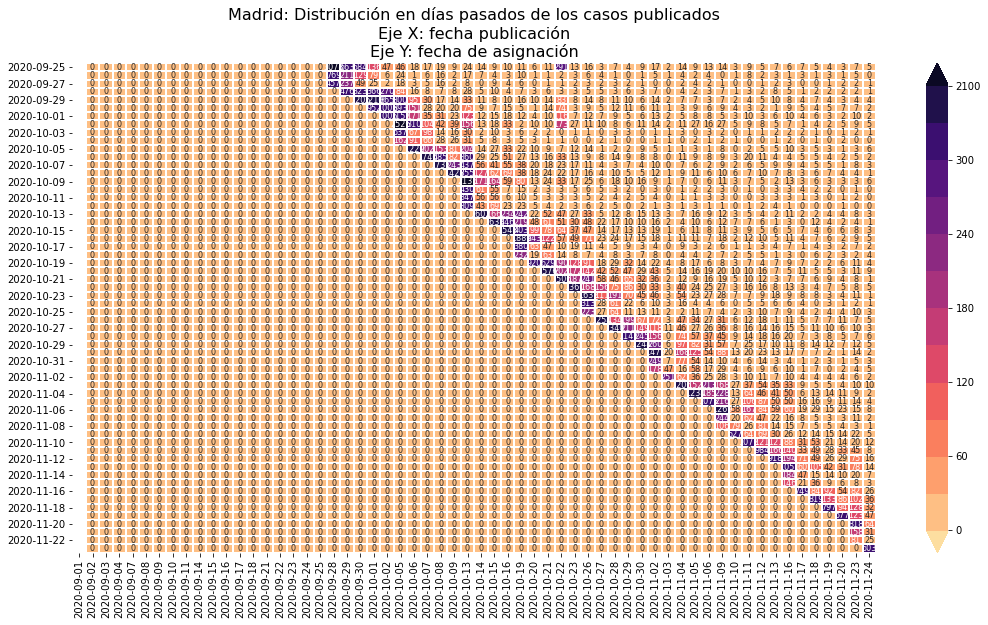

In [24]:
f, ax = plt.subplots(figsize=(18, 9))
sns.heatmap(df[df.index[-60]:], annot=True, cmap=cmap,fmt='0.0f',norm=norm,linewidths=1, 
            ax=ax,annot_kws={"fontsize":8})
ax.set_title('Madrid: Distribución en días pasados de los casos publicados\nEje X: fecha publicación\nEje Y: fecha de asignación',fontsize=16)
f.savefig('distribucion_2)')

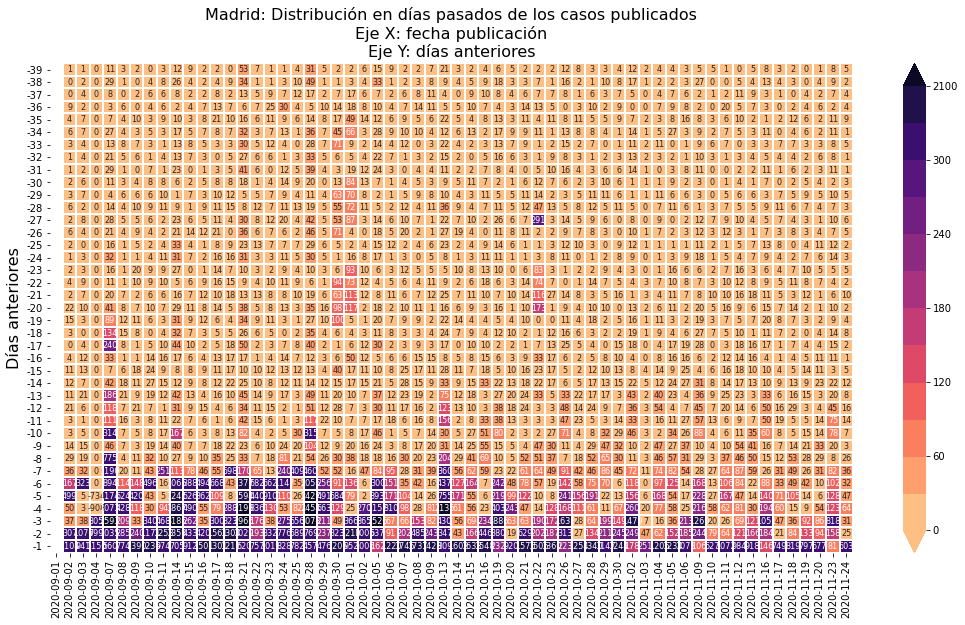

In [25]:
f, ax = plt.subplots(figsize=(18, 9))
sns.heatmap(df1[df1.index>-40], annot=True, cmap=cmap,fmt='0.0f',norm=norm,linewidths=1, 
            ax=ax,annot_kws={"fontsize":8})
ax.set_title('Madrid: Distribución en días pasados de los casos publicados\nEje X: fecha publicación\nEje Y: días anteriores',fontsize=16)
ax.set_ylabel('Días anteriores',fontsize=16)
f.savefig('graficos/distribucion_madrid')

In [26]:
df1.loc[:,'2020-10-26'].tail(20)

-20       9.0
-19      11.0
-18      16.0
-17      25.0
-16       6.0
-15       5.0
-14       6.0
-13      33.0
-12      48.0
-11      47.0
-10      71.0
-9       11.0
-8        7.0
-7       91.0
-6      142.0
-5      241.0
-4      168.0
-3     1632.0
-2      313.0
-1      223.0
Name: 2020-10-26, dtype: float64

In [27]:
df1['2020-10-20'].sum()

1900.0


Lo que podemos observar a primera vista es que en los últimos días se han asignado muchos casos a fechas entre **t-19** y **t-29**, al menos muchos más casos de los que se pasaban en días anteriores.

Recordemos que estas asignaciones provocan que aumente la IA14 de hace un par de semanas con lo cual la ratio mejora. Aquí no 

## Variante con porcentuales

In [28]:
df2 = df1.apply(lambda x: x/x.sum()*100,axis=0)

In [95]:
#preparación de la paleta de colores, dando más granularidad a los valores bajos
# 10 rangos entre 0 y 300, y 3 entre 300 y 3000.
rango_valores_1 = np.arange(0,60,1)
#rango_valores_2 = np.arange(300,3000,900)
#rango_valores = np.concatenate([rango_valores_1,rango_valores_2])
colores = sns.color_palette("magma_r",len(rango_valores_1)+1)
cmap, norm = colors.from_levels_and_colors(
    rango_valores_1, 
    colores,extend = 'both')

In [96]:
df2

,2020-09-01,2020-09-02,2020-09-03,2020-09-04,2020-09-07,2020-09-08,2020-09-09,2020-09-10,2020-09-11,2020-09-14,2020-09-15,2020-09-16,2020-09-17,2020-09-18,2020-09-21,2020-09-22,2020-09-23,2020-09-24,2020-09-25,2020-09-28,2020-09-29,2020-09-30,2020-10-01,2020-10-02,2020-10-05,2020-10-06,2020-10-07,2020-10-08,2020-10-09,2020-10-13,2020-10-14,2020-10-15,2020-10-16,2020-10-19,2020-10-20,2020-10-21,2020-10-22,2020-10-23,2020-10-26,2020-10-27,2020-10-28,2020-10-29,2020-10-30,2020-11-02,2020-11-03,2020-11-04,2020-11-05,2020-11-06,2020-11-09,2020-11-10,2020-11-11,2020-11-12,2020-11-13,2020-11-16,2020-11-17,2020-11-18,2020-11-19,2020-11-20,2020-11-23,2020-11-24
-273,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
-272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
-271,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
-270,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
-269,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
-5,NaN,19.067635,0.174886,-119.934641,9.668918,21.428571,14.909478,1.068588,0.137363,10.914688,14.387309,10.544713,2.223582,0.156740,12.453125,11.950027,23.890785,2.588235,0.833066,16.220009,16.832362,15.312008,1.819438,0.051881,12.413122,6.465028,3.495798,0.444303,1.040416,10.916715,6.261443,1.858736,0.18750,4.810015,5.210526,3.546512,0.270563,0.303030,6.035562,6.939502,7.001466,0.868878,0.528885,4.339360,1.183432,6.516680,2.067381,0.724329,6.499430,2.218570,7.353589,1.964883,0.688637,4.807692,4.680290,5.813953,0.810185,0.404313,5.107741,3.563306
-4,NaN,1.910585,0.104932,-148.366013,8.837094,14.697802,4.188853,0.745527,2.582418,16.420405,13.402626,1.602097,1.611587,5.642633,17.132812,22.705052,3.412969,1.247059,2.627363,16.400454,22.728831,3.382276,0.575772,7.003891,16.082847,11.720227,3.294118,0.888607,3.241297,30.870445,2.233614,1.892531,0.71875,8.851307,12.789474,1.366279,0.378788,4.848485,4.207363,4.937722,2.236070,0.434439,2.725793,7.232267,3.944773,2.986811,2.220521,1.065190,6.157355,4.765818,2.730075,3.386288,1.475652,6.662088,3.955175,0.830565,0.520833,3.638814,4.908220,4.852161
-3,NaN,1.413833,1.329136,49.836601,21.355625,7.177198,1.171459,8.449304,12.857143,28.021108,7.166302,1.019516,6.119951,16.124608,23.171875,4.780011,0.997637,6.470588,21.018904,20.570741,7.233459,1.284740,8.429295,22.438392,35.112594,2.533081,2.218487,4.855601,3.281313,6.217467,2.050531,2.331869,7.31250,41.423237,3.315789,1.831395,5.140693,6.515152,40.871525,1.245552,2.346041,7.859400,6.061839,41.140473,1.380671,0.620636,1.378254,9.075415,36.174458,1.643385,1.144870,2.884615,5.951795,36.092033,3.098220,1.993355,5.324074,5.795148,32.641660,2.350265
-2,NaN,11.730990,37.635537,130.555556,8.524131,9.787088,8.519702,29.100398,34.560440,11.899736,11.843545,12.234197,31.844145,25.548589,8.039062,5.241716,8.716198,

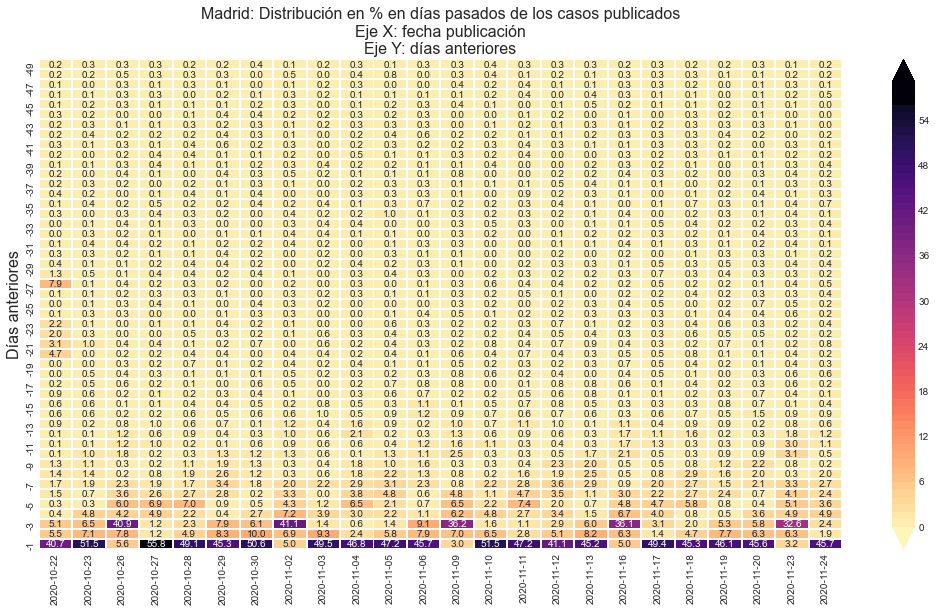

In [97]:
f, ax = plt.subplots(figsize=(18, 9))
sns.heatmap(df2[df2.index>-50][df2.columns[-24:]], annot=True, cmap=cmap,fmt='0.1f',norm=norm,linewidths=1, 
            ax=ax,annot_kws={"fontsize":10})
ax.set_title('Madrid: Distribución en % en días pasados de los casos publicados\nEje X: fecha publicación\nEje Y: días anteriores',fontsize=16)
ax.set_ylabel('Días anteriores',fontsize=16)
f.savefig('graficos/distribucion_madrid_pct')

In [89]:
acumm=pd.DataFrame()

In [90]:
acumm[1] = df2.apply(lambda x:x[x.index>=-1].sum(),axis=0)
acumm[14] = df2.apply(lambda x:x[x.index>=-14].sum(),axis=0)
acumm[21] = df2.apply(lambda x:x[x.index>=-21].sum(),axis=0)
acumm[100] = df2.apply(lambda x:x[x.index>=-100].sum(),axis=0)
acumm = acumm.drop('2020-09-04',axis=0)

In [82]:
acumm[1] = df2.apply(lambda x:x[x.index>=-1].sum(),axis=0)
acumm[4] = df2.apply(lambda x:x[x.index>=-4].sum(),axis=0)
acumm[10] = df2.apply(lambda x:x[x.index>=-10].sum(),axis=0)
acumm[100] = df2.apply(lambda x:x[x.index>=-100].sum(),axis=0)
acumm = acumm.drop('2020-09-04',axis=0)

KeyError: "['2020-09-04'] not found in axis"

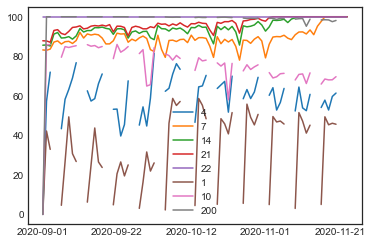

In [78]:
acumm.plot()

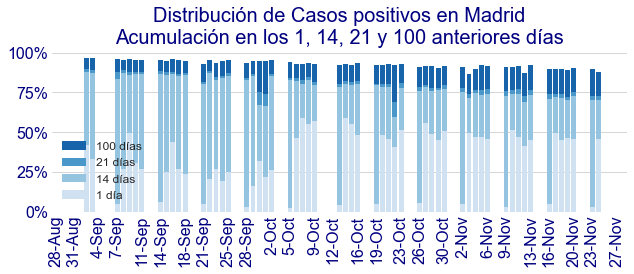

In [94]:
colores = sns.color_palette("Blues_r", 4)

titulo='Distribución de Casos positivos en Madrid\nAcumulación en los 1, 14, 21 y 100 anteriores días'
plt.style.use('seaborn-white')
#f.suptitle(titulo,fontsize=20,x=0.5,y=1,color=color_titulos)
f = plt.figure(figsize=(10,5))
ax1 = f.add_subplot(1,1,1,)

#ax1.bar(datos['date'].unique(),datos[clave_casos_popu],color='red')
#ax1.bar(pd.to_datetime(acumm.index[:]), acumm[1].values[:],color='navy')

ax1.bar(pd.to_datetime(acumm.index[:]),acumm[100].values[:],color=colores[0],label='100 días')
ax1.bar(pd.to_datetime(acumm.index[:]), acumm[21].values[:],color=colores[1],label='21 días')
ax1.bar(pd.to_datetime(acumm.index[:]), acumm[14].values[:],color=colores[2],label='14 días')
ax1.bar(pd.to_datetime(acumm.index[:]), acumm[1].values[:],color=colores[3],label='1 día')

#ax1.set_ylabel(y1,size=18,labelsize = 16, color='navy')
ax1.xaxis.set_tick_params(labelsize=16,labelcolor='navy',rotation=90)
ax1.yaxis.set_tick_params(labelsize=16,labelcolor='navy',width=0)
ax1.set_title(titulo,size=20,color='navy')
ax1.set_xlim()
#ax.bar(tiempo,valores,label='sin',color=colors,width=.25)


fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
xticks = ticker.FormatStrFormatter(fmt)
ax1.yaxis.set_major_formatter(xticks)

XmajorFmt = DateFormatter('%-d-%b')
ax1.xaxis.set_major_formatter(XmajorFmt)
ax1.xaxis.set_major_locator(WeekdayLocator([0,4]))
ax1.legend(loc=3,framealpha=0,fancybox=True,fontsize='large',facecolor='blue')
#ax1.spines['upper'].set_visible('False')


#ax2.set_ylabel('media móvil 7 días',size=18,color='red')
#ax2.set_yticks([])
ax1.grid(True,axis='y')
#f.text(0.1, 0.1, 'Data Source:{} {}'.format(hashtag_fuente,path_montera34[:-9]), horizontalalignment='left',
#       verticalalignment='center', fontsize=12,color=color_titulos)
#f.text(0.1,0.02,'#python code:{}'.format(github_url),
 #          fontsize=12,horizontalalignment='left',color=color_titulos)
[spine.set_visible(False) for spine in ax1.spines.values()]
f.tight_layout(w_pad=0,h_pad=0,pad=5)

f.savefig('graficos/casos+distri_madrid.png',dpi=200)

In [80]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


# Distribución desde el punto de vista de la fecha a la que se asignan los casos positivos (idea de David)

In [51]:
df3 = df.copy()

In [52]:
df3 = df3[df3.index>='2020-09-01']

In [53]:
df3

,2020-09-01,2020-09-02,2020-09-03,2020-09-04,2020-09-07,2020-09-08,2020-09-09,2020-09-10,2020-09-11,2020-09-14,2020-09-15,2020-09-16,2020-09-17,2020-09-18,2020-09-21,2020-09-22,2020-09-23,2020-09-24,2020-09-25,2020-09-28,2020-09-29,2020-09-30,2020-10-01,2020-10-02,2020-10-05,2020-10-06,2020-10-07,2020-10-08,2020-10-09,2020-10-13,2020-10-14,2020-10-15,2020-10-16,2020-10-19,2020-10-20,2020-10-21,2020-10-22,2020-10-23,2020-10-26,2020-10-27,2020-10-28,2020-10-29,2020-10-30,2020-11-02,2020-11-03,2020-11-04,2020-11-05,2020-11-06,2020-11-09,2020-11-10,2020-11-11,2020-11-12,2020-11-13,2020-11-16,2020-11-17,2020-11-18,2020-11-19,2020-11-20,2020-11-23,2020-11-24
2020-09-01,NaN,1104.0,1076.0,305.0,894.0,20.0,11.0,19.0,17.0,42.0,9.0,9.0,13.0,18.0,38.0,13.0,10.0,9.0,5.0,42.0,5.0,63.0,84.0,12.0,28.0,6.0,7.0,8.0,8.0,17.0,6.0,6.0,11.0,8.0,4.0,9.0,12.0,4.0,6.0,7.0,6.0,5.0,10.0,14.0,1.0,7.0,12.0,6.0,13.0,3.0,7.0,6.0,4.0,5.0,2.0,1.0,7.0,4.0,7.0,5.0
2020-09-02,NaN,0.0,941.0,799.0,1174.0,114.0,11.0,32.0,14.0,31.0,13.0,8.0,11.0,17.0,34.0,5.0,8.0,11.0,4.0,46.0,5.0,55.0,70.0,13.0,14.0,9.0,9.0,14.0,11.0,12.0,7.0,8.0,6.0,8.0,3.0,9.0,11.0,6.0,13.0,5.0,5.0,6.0,6.0,8.0,2.0,4.0,7.0,7.0,9.0,5.0,2.0,3.0,2.0,10.0,2.0,2.0,4.0,5.0,10.0,0.0
2020-09-03,NaN,0.0,0.0,1150.0,1073.0,624.0,148.0,43.0,10.0,22.0,9.0,4.0,12.0,17.0,26.0,9.0,8.0,8.0,9.0,29.0,5.0,53.0,72.0,8.0,22.0,4.0,10.0,5.0,11.0,19.0,7.0,6.0,4.0,8.0,4.0,11.0,8.0,19.0,12.0,4.0,23.0,21.0,5.0,6.0,4.0,14.0,8.0,4.0,4.0,2.0,3.0,6.0,3.0,15.0,3.0,3.0,6.0,2.0,4.0,3.0
2020-09-04,NaN,0.0,0.0,0.0,2593.0,428.0,420.0,496.0,251.0,167.0,7.0,15.0,16.0,22.0,50.0,6.0,11.0,13.0,10.0,30.0,6.0,71.0,87.0,11.0,24.0,7.0,12.0,10.0,6.0,21.0,2.0,7.0,7.0,17.0,4.0,17.0,6.0,7.0,12.0,7.0,6.0,8.0,7.0,9.0,2.0,11.0,5.0,4.0,11.0,5.0,6.0,8.0,3.0,6.0,2.0,6.0,1.0,4.0,8.0,3.0
2020-09-05,NaN,0.0,0.0,0.0,1035.0,209.0,118.0,43.0,16.0,40.0,6.0,6.0,4.0,10.0,17.0,2.0,5.0,3.0,3.0,10.0,5.0,5.0,4.0,3.0,7.0,3.0,1.0,0.0,4.0,9.0,3.0,2.0,2.0,5.0,2.0,4.0,2.0,5.0,2.0,0.0,1.0,1.0,1.0,2.0,0.0,2.0,4.0,1.0,1.0,0.0,4.0,0.0,4.0,3.0,2.0,1.0,2.0,2.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-19,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,677.0,123.0,47.0
2020-11-20,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,818.0,64.0
2020-11-21,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,158.0,31.0
2020-11-22,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,81.0,25.0


In [54]:
fecha_inicial = datetime.strptime(df3.columns[0],'%Y-%m-%d')
fecha_prueba = datetime.strptime(df3.columns[5],'%Y-%m-%d')

In [55]:
df4=pd.DataFrame()
un_dia=dt.timedelta(days=1)
for i,fecha_adj in enumerate(df3.index):
    for j,fecha_pub in enumerate(df3.index):
        try:
            df4.loc[fecha_adj,j] = df3.loc[fecha_adj,
                                           (datetime.strptime(fecha_adj,'%Y-%m-%d')+\
                                            j*un_dia).strftime('%Y-%m-%d')]
        except:
            df4.loc[fecha_adj,j] = 0

In [56]:
df4.to_csv('numeros_madrid.csv')

In [57]:
df4

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83
2020-09-01,NaN,1104.0,1076.0,305.0,0.0,0.0,894.0,20.0,11.0,19.0,17.0,0.0,0.0,42.0,9.0,9.0,13.0,18.0,0.0,0.0,38.0,13.0,10.0,9.0,5.0,0.0,0.0,42.0,5.0,63.0,84.0,12.0,0.0,0.0,28.0,6.0,7.0,8.0,8.0,0.0,0.0,0.0,17.0,6.0,6.0,11.0,0.0,0.0,8.0,4.0,9.0,12.0,4.0,0.0,0.0,6.0,7.0,6.0,5.0,10.0,0.0,0.0,14.0,1.0,7.0,12.0,6.0,0.0,0.0,13.0,3.0,7.0,6.0,4.0,0.0,0.0,5.0,2.0,1.0,7.0,4.0,0.0,0.0,7.0
2020-09-02,0.0,941.0,799.0,0.0,0.0,1174.0,114.0,11.0,32.0,14.0,0.0,0.0,31.0,13.0,8.0,11.0,17.0,0.0,0.0,34.0,5.0,8.0,11.0,4.0,0.0,0.0,46.0,5.0,55.0,70.0,13.0,0.0,0.0,14.0,9.0,9.0,14.0,11.0,0.0,0.0,0.0,12.0,7.0,8.0,6.0,0.0,0.0,8.0,3.0,9.0,11.0,6.0,0.0,0.0,13.0,5.0,5.0,6.0,6.0,0.0,0.0,8.0,2.0,4.0,7.0,7.0,0.0,0.0,9.0,5.0,2.0,3.0,2.0,0.0,0.0,10.0,2.0,2.0,4.0,5.0,0.0,0.0,10.0,0.0
2020-09-03,0.0,1150.0,0.0,0.0,1073.0,624.0,148.0,43.0,10.0,0.0,0.0,22.0,9.0,4.0,12.0,17.0,0.0,0.0,26.0,9.0,8.0,8.0,9.0,0.0,0.0,29.0,5.0,53.0,72.0,8.0,0.0,0.0,22.0,4.0,10.0,5.0,11.0,0.0,0.0,0.0,19.0,7.0,6.0,4.0,0.0,0.0,8.0,4.0,11.0,8.0,19.0,0.0,0.0,12.0,4.0,23.0,21.0,5.0,0.0,0.0,6.0,4.0,14.0,8.0,4.0,0.0,0.0,4.0,2.0,3.0,6.0,3.0,0.0,0.0,15.0,3.0,3.0,6.0,2.0,0.0,0.0,4.0,3.0,0.0
2020-09-04,0.0,0.0,0.0,2593.0,428.0,420.0,496.0,251.0,0.0,0.0,167.0,7.0,15.0,16.0,22.0,0.0,0.0,50.0,6.0,11.0,13.0,10.0,0.0,0.0,30.0,6.0,71.0,87.0,11.0,0.0,0.0,24.0,7.0,12.0,10.0,6.0,0.0,0.0,0.0,21.0,2.0,7.0,7.0,0.0,0.0,17.0,4.0,17.0,6.0,7.0,0.0,0.0,12.0,7.0,6.0,8.0,7.0,0.0,0.0,9.0,2.0,11.0,5.0,4.0,0.0,0.0,11.0,5.0,6.0,8.0,3.0,0.0,0.0,6.0,2.0,6.0,1.0,4.0,0.0,0.0,8.0,3.0,0.0,0.0
2020-09-05,0.0,0.0,1035.0,209.0,118.0,43.0,16.0,0.0,0.0,40.0,6.0,6.0,4.0,10.0,0.0,0.0,17.0,2.0,5.0,3.0,3.0,0.0,0.0,10.0,5.0,5.0,4.0,3.0,0.0,0.0,7.0,3.0,1.0,0.0,4.0,0.0,0.0,0.0,9.0,3.0,2.0,2.0,0.0,0.0,5.0,2.0,4.0,2.0,5.0,0.0,0.0,2.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,4.0,1.0,0.0,0.0,1.0,0.0,4.0,0.0,4.0,0.0,0.0,3.0,2.0,1.0,2.0,2.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-19,0.0,677.0,0.0,0.0,123.0,47.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-11-20,0.0,0.0,0.0,818.0,64.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-11-21,0.0,0.0,158.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-11-22,0.0,81.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
df4.loc['2020-10-23',:]

0        0.0
1        0.0
2        0.0
3     1632.0
4      111.0
       ...  
79       0.0
80       0.0
81       0.0
82       0.0
83       0.0
Name: 2020-10-23, Length: 84, dtype: float64

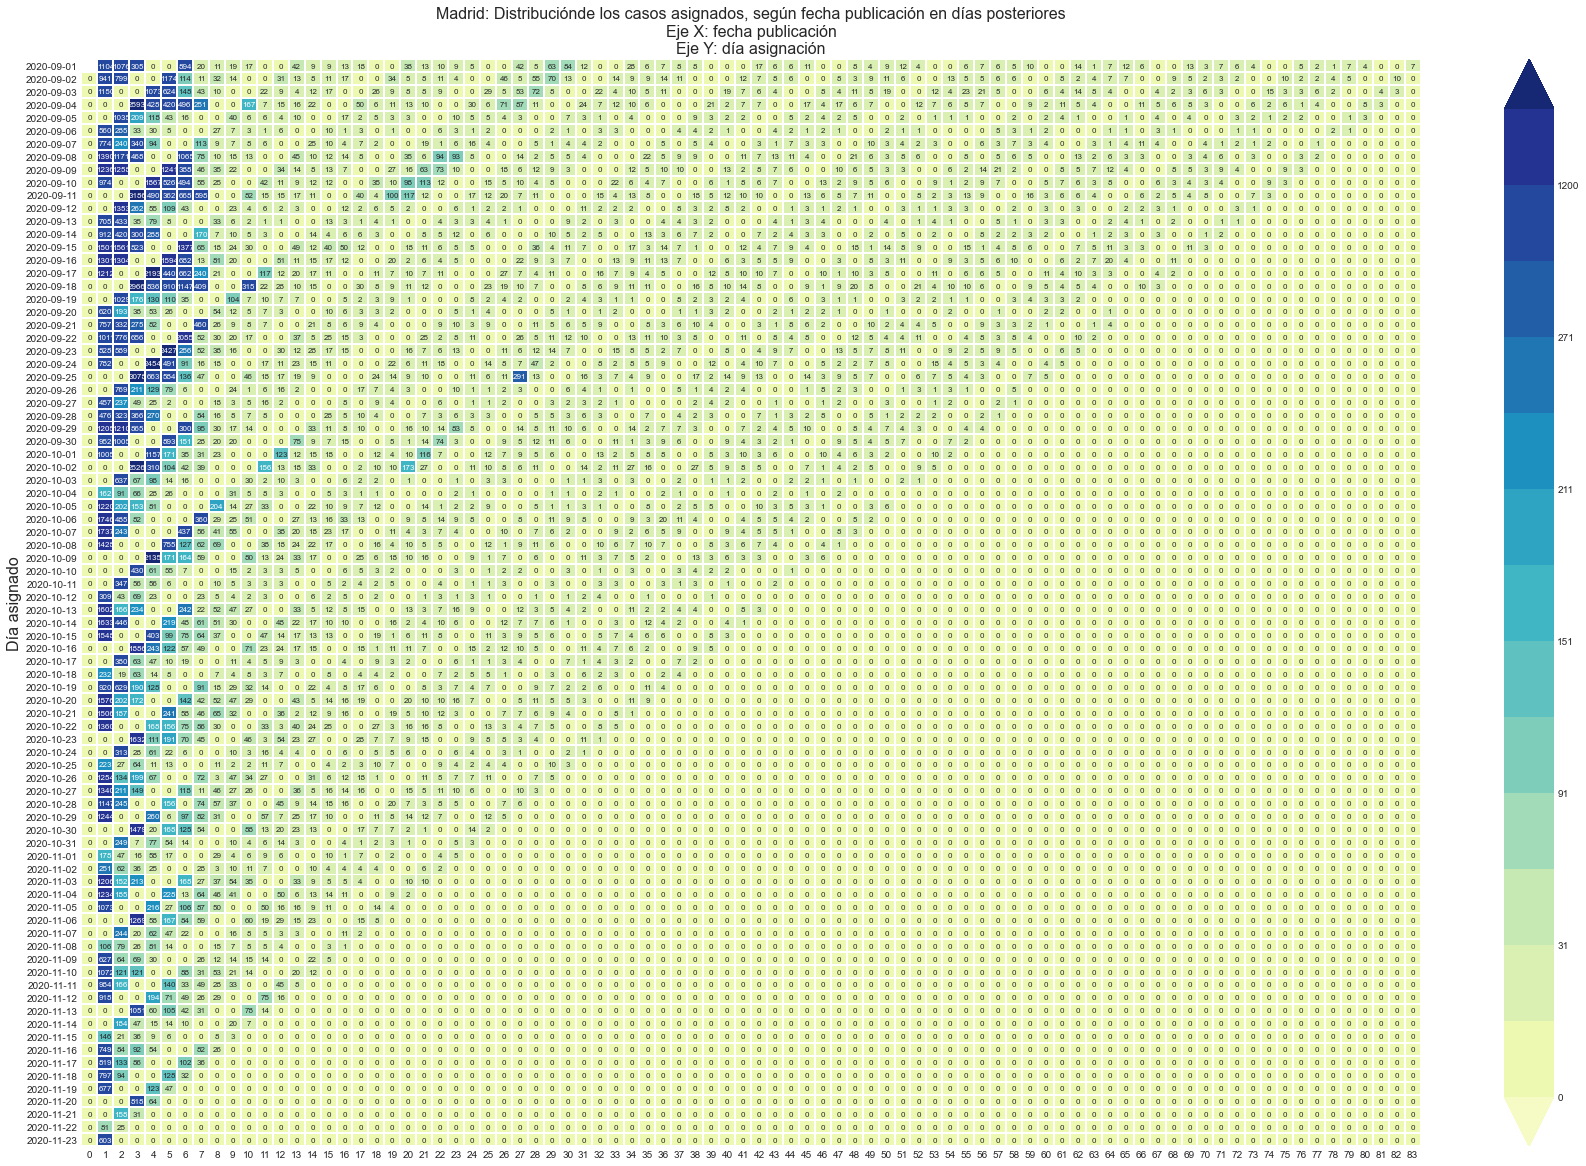

In [60]:
#preparación de la paleta de colores, dando más granularidad a los valores bajos
# 10 rangos entre 0 y 300, y 3 entre 300 y 3000.
rango_valores_0 = np.arange(0,1,1)
rango_valores_1 = np.arange(1,300,30)
rango_valores_2 = np.arange(300,3000,900)
rango_valores = np.concatenate([rango_valores_0,rango_valores_1,rango_valores_2])
colores = sns.color_palette("YlGnBu",len(rango_valores)+1)
cmap, norm = colors.from_levels_and_colors(
    rango_valores, 
    colores,extend = 'both')
f, ax1 = plt.subplots(figsize=(30, 20))
sns.heatmap(df4, annot=True, cmap=cmap,fmt='0.0f',norm=norm,linewidths=1, 
            ax=ax1,annot_kws={"fontsize":8})
ax1.set_title('Madrid: Distribuciónde los casos asignados, según fecha publicación en días posteriores\nEje X: fecha publicación\nEje Y: día asignación',fontsize=16)
ax1.set_ylabel('Día asignado',fontsize=16)
f.savefig('graficos/distribucion_asignados_madrid.png',dpi=144)

## Y ahora en porcentajes

In [61]:
df5 = df4.apply(lambda x: x/x.sum()*100,axis=1)

In [62]:
df5

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83
2020-09-01,NaN,27.025704,26.340269,7.466340,0.000000,0.000000,21.884945,0.489596,0.269278,0.465116,0.416157,0.000000,0.000000,1.028152,0.220318,0.220318,0.318237,0.440636,0.000000,0.000000,0.930233,0.318237,0.244798,0.220318,0.122399,0.000000,0.000000,1.028152,0.122399,1.542228,2.056304,0.293758,0.000000,0.000000,0.685435,0.146879,0.171359,0.195838,0.195838,0.000000,0.000000,0.000000,0.416157,0.146879,0.146879,0.269278,0.000000,0.000000,0.195838,0.097919,0.220318,0.293758,0.097919,0.000000,0.000000,0.146879,0.171359,0.146879,0.122399,0.244798,0.000000,0.000000,0.342717,0.024480,0.171359,0.293758,0.146879,0.000000,0.000000,0.318237,0.073439,0.171359,0.146879,0.097919,0.000000,0.000000,0.122399,0.048960,0.024480,0.171359,0.097919,0.000000,0.000000,0.171359
2020-09-02,0.0,25.710383,21.830601,0.000000,0.000000,32.076503,3.114754,0.300546,0.874317,0.382514,0.000000,0.000000,0.846995,0.355191,0.218579,0.300546,0.464481,0.000000,0.000000,0.928962,0.136612,0.218579,0.300546,0.109290,0.000000,0.000000,1.256831,0.136612,1.502732,1.912568,0.355191,0.000000,0.000000,0.382514,0.245902,0.245902,0.382514,0.300546,0.000000,0.000000,0.000000,0.327869,0.191257,0.218579,0.163934,0.000000,0.000000,0.218579,0.081967,0.245902,0.300546,0.163934,0.000000,0.000000,0.355191,0.136612,0.136612,0.163934,0.163934,0.000000,0.000000,0.218579,0.054645,0.109290,0.191257,0.191257,0.000000,0.000000,0.245902,0.136612,0.054645,0.081967,0.054645,0.000000,0.000000,0.273224,0.054645,0.054645,0.109290,0.136612,0.000000,0.000000,0.273224,0.000000
2020-09-03,0.0,31.662996,0.000000,0.000000,29.542952,17.180617,4.074890,1.183921,0.275330,0.000000,0.000000,0.605727,0.247797,0.110132,0.330396,0.468062,0.000000,0.000000,0.715859,0.247797,0.220264,0.220264,0.247797,0.000000,0.000000,0.798458,0.137665,1.459251,1.982379,0.220264,0.000000,0.000000,0.605727,0.110132,0.275330,0.137665,0.302863,0.000000,0.000000,0.000000,0.523128,0.192731,0.165198,0.110132,0.000000,0.000000,0.220264,0.110132,0.302863,0.220264,0.523128,0.000000,0.000000,0.330396,0.110132,0.633260,0.578194,0.137665,0.000000,0.000000,0.165198,0.110132,0.385463,0.220264,0.110132,0.000000,0.000000,0.110132,0.055066,0.082599,0.165198,0.082599,0.000000,0.000000,0.412996,0.082599,0.082599,0.165198,0.055066,0.000000,0.000000,0.110132,0.082599,0.000000
2020-09-04,0.0,0.000000,0.000000,51.953516,8.575436,8.415147,9.937888,5.029052,0.000000,0.000000,3.346023,0.140252,0.300541,0.320577,0.440793,0.000000,0.000000,1.001803,0.120216,0.220397,0.260469,0.200361,0.000000,0.000000,0.601082,0.120216,1.422561,1.743138,0.220397,0.000000,0.000000,0.480866,0.140252,0.240433,0.200361,0.120216,0.000000,0.000000,0.000000,0.420757,0.040072,0.140252,0.140252,0.000000,0.000000,0.340613,0.080144,0.340613,0.120216,0.140252,0.000000,0.000000,0.240433,0.140252,0.120216,0.160289,0.140252,0.000000,0.000000,0.180325,0.040072,0.220397,0.100180,0.080144,0.000000,0.000000,0.220397,0.100180,0.120216,0.160289,0.060108,0.000000,0.000000,0.120216,0.040072,0.120216,0.020036,0.080144,0.000000,0.000000,0.160289,0.060108,0.000000,0.000000
2020-09-05,0.0,0.000000,63.496933,12.822086,7.239264,2.638037,0.981595,0.000000,0.000000,2.453988,0.368098,0.368098,0.245399,0.613497,0.000000,0.000000,1.042945,0.122699,0.306748,0.184049,0.184049,0.000000,0.000000,0.613497,0.306748,0.306748,0.245399,0.184049,0.000000,0.000000,0.429448,0.184049,0.061350,0.000000,0.245399,0.000000,0.000000,0.000000,0.552147,0.184049,0.122699,0.122699,0.000000,0.000000,0.306748,0.122699,0.245399,0.122699,0.306748,0.000000,0.000000,0.122699,0.000000,0.061350,0.061350,0.061350,0.000000,0.000000,0.122699,0.000000,0.122699,0.245399,0.061350,0.000000,0.000000,0.061350,0.000000,0.245399,0.000000,0.245399,0.000000,0.000000,0.184049,0.122699,0.061350,0.122699,0.12269

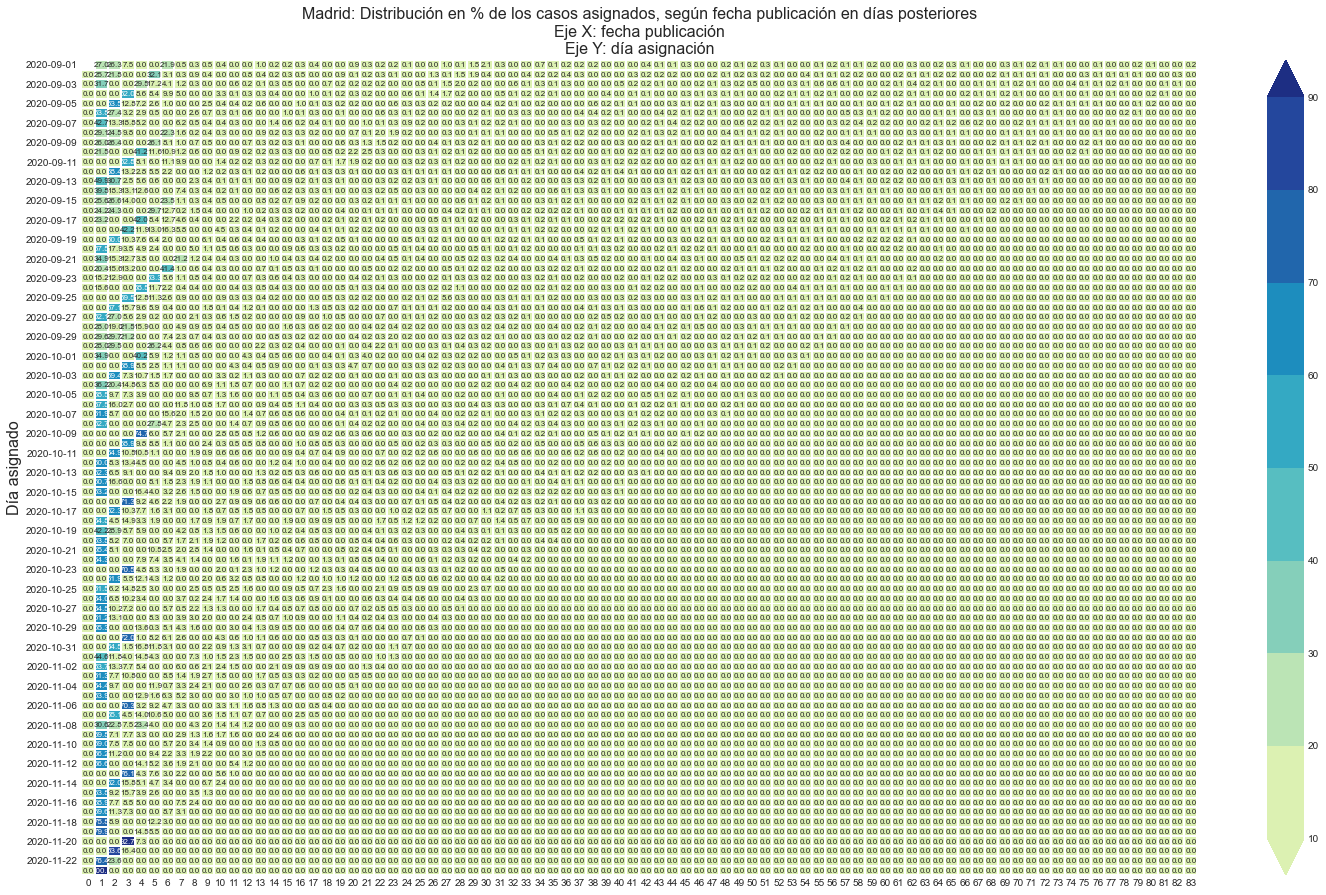

In [63]:
#preparación de la paleta de colores, dando más granularidad a los valores bajos
# 10 rangos entre 0 y 300, y 3 entre 300 y 3000.
rango_valores_1 = np.arange(10,100,10)
rango_valores_0 = np.arange(0,10,1)
rango_valores = np.concatenate([rango_valores_0,rango_valores_1])
colores = sns.color_palette("YlGnBu",len(rango_valores_1)+1)
cmap, norm = colors.from_levels_and_colors(
    rango_valores_1, 
    colores,extend = 'both')
f, ax = plt.subplots(figsize=(25, 15))
sns.heatmap(df5, annot=True, cmap=cmap,fmt='0.1f',norm=norm,linewidths=1, 
            ax=ax,annot_kws={"fontsize":8})
ax.set_title('Madrid: Distribución en % de los casos asignados, según fecha publicación en días posteriores\nEje X: fecha publicación\nEje Y: día asignación',fontsize=16)
ax.set_ylabel('Día asignado',fontsize=16)
f.savefig('graficos/distribucion_asignados_pct_madrid_pct')

In [64]:
acumm=pd.DataFrame()
acumm[4] = df5.apply(lambda x:x[x.index<=4].sum(),axis=1)
acumm[7] = df5.apply(lambda x:x[x.index<=7].sum(),axis=1)
acumm[14] = df5.apply(lambda x:x[x.index<=14].sum(),axis=1)
acumm[21] = df5.apply(lambda x:x[x.index<=21].sum(),axis=1)
acumm[22] = df5.apply(lambda x:x.sum(),axis=1)
#acumm = acumm.drop('2020-09-04',axis=0)

In [65]:
acumm

,4,7,14,21,22
2020-09-01,60.832313,83.206854,85.605875,87.833537,100.0
2020-09-02,47.540984,83.032787,85.710383,87.759563,100.0
2020-09-03,61.205947,83.645374,85.214758,87.087004,100.0
2020-09-04,60.528952,83.911040,88.459227,90.262472,100.0
2020-09-05,83.558282,87.177914,91.226994,93.067485,100.0
...,...,...,...,...,...
2020-11-19,94.451004,100.000000,100.000000,100.000000,100.0
2020-11-20,100.000000,100.000000,100.000000,100.000000,100.0
2020-11-21,100.000000,100.000000,100.000000,100.000000,100.0
2020-11-22,100.000000,100.000000,100.000000,100.000000,100.0


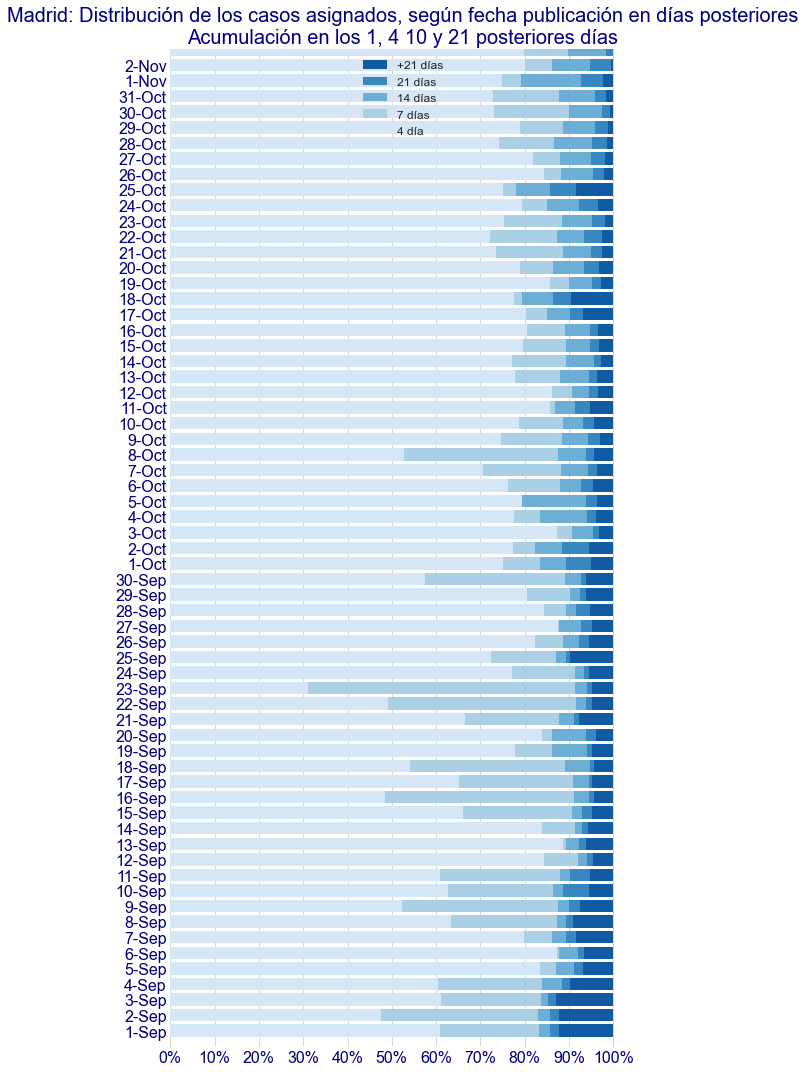

In [66]:
colores = sns.color_palette("Blues_r", 5)

titulo= 'Madrid: Distribución de los casos asignados, según fecha publicación en días posteriores\nAcumulación en los 1, 4 10 y 21 posteriores días'
plt.style.use('seaborn-white')
#f.suptitle(titulo,fontsize=20,x=0.5,y=1,color=color_titulos)
f = plt.figure(figsize=(10,15))
ax1 = f.add_subplot(1,1,1,)

inicio_rango = 0
fin_rango = -1
#ax1.bar(datos['date'].unique(),datos[clave_casos_popu],color='red')
#ax1.bar(pd.to_datetime(acumm.index[:]), acumm[1].values[:],color='navy')

ax1.barh(pd.to_datetime(acumm.index[:]),acumm[22].values[:],color=colores[0],label='+21 días')
ax1.barh(pd.to_datetime(acumm.index[:]),acumm[21].values[:],color=colores[1],label='21 días')
ax1.barh(pd.to_datetime(acumm.index[:]), acumm[14].values[:],color=colores[2],label='14 días')
ax1.barh(pd.to_datetime(acumm.index[:]), acumm[7].values[:],color=colores[3],label='7 días')
ax1.barh(pd.to_datetime(acumm.index[:]), acumm[4].values[:],color=colores[4],label='4 día')

#ax1.set_ylabel(y1,size=18,labelsize = 16, color='navy')
ax1.yaxis.set_tick_params(labelsize=16,labelcolor='navy')
ax1.xaxis.set_tick_params(labelsize=16,labelcolor='navy',width=0)
ax1.set_title(titulo,size=20,color='navy')
ax1.set_xlim()
#ax.bar(tiempo,valores,label='sin',color=colors,width=.25)


fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
xticks = ticker.FormatStrFormatter(fmt)
ax1.xaxis.set_major_formatter(xticks)
ax1.set_xticks([0,10,20,30,40,50,60,70,80,90,100])
YmajorFmt = DateFormatter('%-d-%b')
ax1.yaxis.set_major_formatter(YmajorFmt)
ax1.yaxis.set_major_locator(WeekdayLocator([0,1,2,3,4,5,6]))

#ax1.yaxis.set_major_locator(mdates.AutoDateLocator())
#ax1.yaxis.set_major_locator(acumm.index[:])
ax1.legend(loc=9,framealpha=0,fancybox=True,fontsize='large',facecolor='blue')
#ax1.spines['upper'].set_visible('False')
ax1.set_ylim(datetime(2020,8,31),datetime(2020,11,3))
ax1.set_yticks(ax1.get_yticks()[1:-1])
#plt.gca().set_ybound(datetime(2020,9,1),datetime(2020,10,22))
#ax2.set_ylabel('media móvil 7 días',size=18,color='red')
#ax2.set_yticks([])
ax1.grid(True,axis='x')
#f.text(0.1, 0.1, 'Data Source:{} {}'.format(hashtag_fuente,path_montera34[:-9]), horizontalalignment='left',
#       verticalalignment='center', fontsize=12,color=color_titulos)
#f.text(0.1,0.02,'#python code:{}'.format(github_url),
 #          fontsize=12,horizontalalignment='left',color=color_titulos)
[spine.set_visible(False) for spine in ax1.spines.values()]
#f.tight_layout(w_pad=0,h_pad=10,pad=5)

#ax1.set_title(titulo,size=20,color='navy')
#f.subplots_adjust(bottom=.1,top=.9)
f.tight_layout()
f.savefig('graficos/resumen_asignados_madrid.png',dpi=200)

In [72]:
acumm.loc[acumm.index[:-21],4].mean()

73.28779902300849

In [73]:
acumm.loc[acumm.index[:-21],7].mean()

87.3297519536651

In [74]:
acumm.loc[acumm.index[:-21],14].mean()

92.4918817903461

In [75]:
acumm.loc[acumm.index[:-21],21].mean()

94.99315315049668

In [71]:
acumm.index[:-21]

Index(['2020-09-01', '2020-09-02', '2020-09-03', '2020-09-04', '2020-09-05',
       '2020-09-06', '2020-09-07', '2020-09-08', '2020-09-09', '2020-09-10',
       '2020-09-11', '2020-09-12', '2020-09-13', '2020-09-14', '2020-09-15',
       '2020-09-16', '2020-09-17', '2020-09-18', '2020-09-19', '2020-09-20',
       '2020-09-21', '2020-09-22', '2020-09-23', '2020-09-24', '2020-09-25',
       '2020-09-26', '2020-09-27', '2020-09-28', '2020-09-29', '2020-09-30',
       '2020-10-01', '2020-10-02', '2020-10-03', '2020-10-04', '2020-10-05',
       '2020-10-06', '2020-10-07', '2020-10-08', '2020-10-09', '2020-10-10',
       '2020-10-11', '2020-10-12', '2020-10-13', '2020-10-14', '2020-10-15',
       '2020-10-16', '2020-10-17', '2020-10-18', '2020-10-19', '2020-10-20',
       '2020-10-21', '2020-10-22', '2020-10-23', '2020-10-24', '2020-10-25',
       '2020-10-26', '2020-10-27', '2020-10-28', '2020-10-29', '2020-10-30',
       '2020-10-31', '2020-11-01', '2020-11-02'],
      dtype='object')